> Copyright 2022 University of Luxembourg
> 
> Licensed under the Apache License, Version 2.0 (the "License");  
> you may not use this file except in compliance with the License.  
> You may obtain a copy of the License at  
>
>    https://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software  
> distributed under the License is distributed on an "AS IS" BASIS,  
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
> See the License for the specific language governing permissions and  
> limitations under the License.  
>
***

Author: André Stemper (andre.stemper@uni.lu)

***

In [1]:
if not 'experiment_timestamp_string' in locals():
    experiment_timestamp_string='20221021-095246'

if not 'measurements_root' in locals():
    measurements_root='./measurements' 

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import time
# import pickle
import sys
import json
import math

Measurement results directory

In [3]:
measurements_directory = measurements_root + os.path.sep + experiment_timestamp_string

**Load settings**

In [4]:
filename = measurements_directory + os.path.sep + 'settings.json'
with open(filename, 'r') as file:
    settings = json.load(file)
    print("Settings loaded from '{}'".format(filename))

print('Settings:')
for k, v in settings.items():
    print(" - {} = {}".format(k, v))

Settings loaded from './measurements/20221021-095246/settings.json'
Settings:
 - timestamp = 20221021-095246
 - dataset = 2022.04.06
 - range = experiment
 - frequency = 146
 - connection_type = remote
 - limit = None
 - threshold_hold_off = 60


### Postprocessing - calculate power from current and voltage traces   
Load current and voltage trace from logger 

In [5]:
dateparser = lambda x: datetime.datetime.strptime(x, '%d/%m/%Y %H:%M:%S.%f')
filename = measurements_directory+os.path.sep+'current.csv'
dataframe_current = pd.read_csv(filename, sep=',', header=2, encoding='utf-8', encoding_errors='replace', index_col='Start Time', parse_dates=True, date_parser=dateparser)
dataframe_current.rename(columns={"Average": "current"}, inplace=True)

for i in ['Reading', 'Duration', 'Max', 'Sample','Max Time','Min Time','Min', 'Stop Time','Unnamed: 2', 'Unnamed: 7',  'Unnamed: 9', 'Unnamed: 12']:
    del dataframe_current[i]


filename = measurements_directory+os.path.sep+'voltage.csv'
dataframe_voltage = pd.read_csv(filename, sep=',', header=2, encoding='utf-8', encoding_errors='replace',  index_col='Start Time',  parse_dates=True, date_parser=dateparser)
dataframe_voltage.rename(columns={"Average": "voltage"}, inplace=True)

for i in ['Reading', 'Duration', 'Max', 'Sample','Max Time','Min Time','Min', 'Stop Time','Unnamed: 2','Unnamed: 7',  'Unnamed: 9', 'Unnamed: 12']:
    del dataframe_voltage[i]


Use only periodically sampled data (not event based data) 

In [6]:
if True:
    dataframe_current = dataframe_current[(dataframe_current['Description']=='Interval')]
    dataframe_voltage = dataframe_voltage[(dataframe_voltage['Description']=='Interval')]
    del dataframe_current['Description']
    del dataframe_voltage['Description']

dataframe_voltage['voltage'] = dataframe_voltage['voltage'].astype('float')
dataframe_current['current'] = dataframe_current['current'].astype('float')

Visualize current data

Number of samples 196


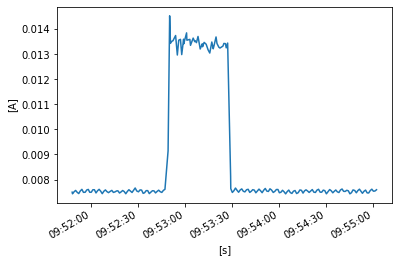

In [7]:
ax=dataframe_current['current'].plot()
ax.set_ylabel("[A]")
ax.set_xlabel("[s]")
filename = measurements_directory + os.path.sep + "current.png"
plt.savefig(filename)
print("Number of samples {}".format(len(dataframe_current['current'])))

Visualize voltage data

Number of samples 197


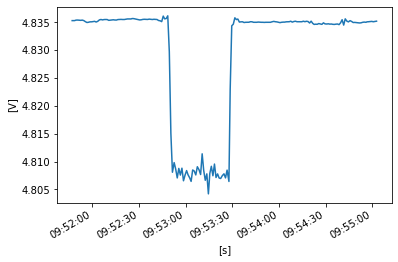

In [8]:
ax=dataframe_voltage['voltage'].plot()
ax.set_ylabel("[V]")
ax.set_xlabel("[s]")
filename = measurements_directory + os.path.sep + "voltage.png"
plt.savefig(filename)
print("Number of samples {}".format(len(dataframe_voltage['voltage'])))

**Merge**

In [9]:
dataframe_current = dataframe_current[~dataframe_current.index.duplicated(keep='first')]
dataframe_voltage = dataframe_voltage[~dataframe_voltage.index.duplicated(keep='first')]
dataframe_power = pd.concat([dataframe_current, dataframe_voltage], axis=1, join='outer')
dataframe_power = dataframe_power.interpolate(limit_direction='both')
filename = measurements_directory + os.path.sep + 'power.csv'
dataframe_power.to_csv(filename, sep=';')


**Calculate power**

In [10]:
dataframe_power['power'] = dataframe_power['voltage'] * dataframe_power['current'] 
if False:
    ax = dataframe_power['power'].plot()
    ax.set_ylabel("[W]")
    ax.set_xlabel("[s]")
    filename = measurements_directory + os.path.sep + "power.png"
    plt.savefig(filename)
    filename = measurements_directory + os.path.sep + "power.pdf"
    plt.savefig(filename)

### Find start / end of experiment based on power consumption

In [11]:
threshold_percentage = 20 # trigger start / end if <threshold_percentage>% above background

In [12]:
power_max = dataframe_power['power'].max()
power_min = dataframe_power['power'].min()

power_threshold = power_min + (power_max - power_min) * threshold_percentage/100.0
experiment_begin = dataframe_power[dataframe_power['power'].gt(power_threshold)].index[0]
print("Experiment begin: {}".format(experiment_begin))
experiment_end = dataframe_power[dataframe_power['power'].gt(power_threshold)].index[-1]
print("Experiment end: {}".format(experiment_end))

if False:
    ax = dataframe_power['power'].plot()
    ax.vlines(x=[experiment_begin, experiment_end], ymin=power_min, ymax=power_max, colors=['r', 'r'])
    ax.hlines(y=[power_threshold], xmin=experiment_begin, xmax=experiment_end, colors=['g'])

    ax.set_ylabel("[W]")
    ax.set_xlabel("[s]")
    filename = measurements_directory + os.path.sep + "power.png"
    plt.savefig(filename)

    filename = measurements_directory + os.path.sep + "power.pdf"
    plt.savefig(filename)


Experiment begin: 2022-10-21 09:52:49.300000
Experiment end: 2022-10-21 09:53:28.700000


In [13]:
experiment_power = dataframe_power['power'].loc[experiment_begin: experiment_end]
#background_power = pd.concat(
#    [dataframe_power['power'].loc[0: experiment_begin],  dataframe_power['power'].loc[experiment_end:]])

background_power = dataframe_power['power'].loc[: experiment_begin]

background_power_std = background_power.std()
experiment_power_std = experiment_power.std()

power_statistics = {
    'experiment': {
        'mean': experiment_power.mean(),
        'std': experiment_power_std,
        'min': experiment_power.min(),
        'max': experiment_power.max(),
        'sample_size': len(experiment_power)
    },
    'background': {
        'mean': background_power.mean(),
        'std':  background_power_std,
        'min':  background_power.min(),
        'max':  background_power.max(),
        'sample_size': len(background_power)

    },
    'difference': {
        'mean': experiment_power.mean() - background_power.mean(),
        'std' : math.sqrt(background_power_std**2 + experiment_power_std**2)
    }
}

filename = measurements_directory + os.path.sep + 'power_statistics.json'
with open(filename, 'w') as file:
    json.dump(power_statistics, file)
    print("Power statistics saved to '{}'".format(filename))

print("Power statistics")
for k, v in power_statistics.items():
    print("{} \t= {} [W]".format(k, v))


Power statistics saved to './measurements/20221021-095246/power_statistics.json'
Power statistics
experiment 	= {'mean': 0.06396572137475971, 'std': 0.003406479718790965, 'min': 0.044197144849999995, 'max': 0.07008379387000001, 'sample_size': 77} [W]
background 	= {'mean': 0.03652897001105534, 'std': 0.0009046514650500629, 'min': 0.0359359496, 'max': 0.044197144849999995, 'sample_size': 125} [W]
difference 	= {'mean': 0.027436751363704374, 'std': 0.003524556475324434} [W]


Experiment begin: 2022-10-21 09:52:49.300000
Experiment end: 2022-10-21 09:53:28.700000


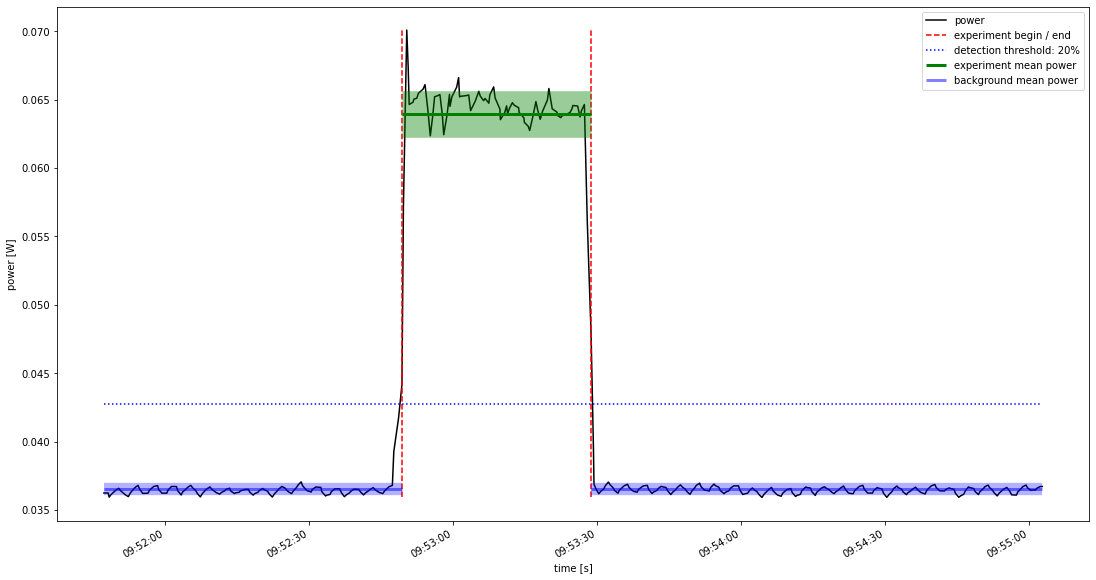

In [14]:

linewidth = 3

power_max = dataframe_power['power'].max()
power_min = dataframe_power['power'].min()

time_begin = dataframe_power.index[0]
time_end  = dataframe_power.index[-1]

power_threshold = power_min + (power_max - power_min) * threshold_percentage/100.0
experiment_begin = dataframe_power[dataframe_power['power'].gt(power_threshold)].index[0]
print("Experiment begin: {}".format(experiment_begin))
experiment_end = dataframe_power[dataframe_power['power'].gt(power_threshold)].index[-1]
print("Experiment end: {}".format(experiment_end))

ax = dataframe_power['power'].plot(color='k')
figure = ax.get_figure()
figure.set_size_inches(18.5, 10.5)

figure = ax.get_figure()
length = 72*figure.bbox_inches.height * ax.get_position().height
value_range = np.diff(ax.get_ylim())
ps= (length / value_range)

ax.vlines(x=[experiment_begin, experiment_end], ymin=power_min, ymax=power_max, colors=['r', 'r'], label='experiment begin / end', linestyles='dashed')
ax.hlines(y=[power_threshold], xmin=time_begin, xmax=time_end, colors=['b'], linestyles='dotted', label= 'detection threshold: {}%'.format(threshold_percentage))
# experiment mean
ax.hlines(y=[experiment_power.mean()], xmin=experiment_begin, xmax=experiment_end, colors=['g'], label='experiment mean power',linewidth=linewidth, alpha=1.0)
ax.hlines(y=[experiment_power.mean()], xmin=experiment_begin, xmax=experiment_end, colors=['g'], linewidth=experiment_power_std*ps, alpha=0.4)
# background mean left side 
ax.hlines(y=[background_power.mean()], xmin=time_begin, xmax=experiment_begin, colors=['b'], label='background mean power',linewidth=linewidth, alpha=0.5)
ax.hlines(y=[background_power.mean()], xmin=time_begin, xmax=experiment_begin, colors=['b'], linewidth=background_power_std*ps, alpha=0.3)

# backround mean right side
ax.hlines(y=[background_power.mean()], xmin=experiment_end, xmax=time_end, colors=['b'],linewidth=linewidth, alpha=0.5)
ax.hlines(y=[background_power.mean()], xmin=experiment_end, xmax=time_end, colors=['b'],linewidth=background_power_std*ps, alpha=0.3)
ax.legend()

ax.set_ylabel("power [W]")
ax.set_xlabel("time [s]")
filename = measurements_directory + os.path.sep + "power.png"
plt.savefig(filename)

filename = measurements_directory + os.path.sep + "power.pdf"
fs = plt.rcParams.get('font.size')
plt.rcParams.update({'font.size': 20})
plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.rcParams.update({'font.size': fs})

Experiment begin: 2022-10-21 09:52:49.300000
Experiment end: 2022-10-21 09:53:28.700000


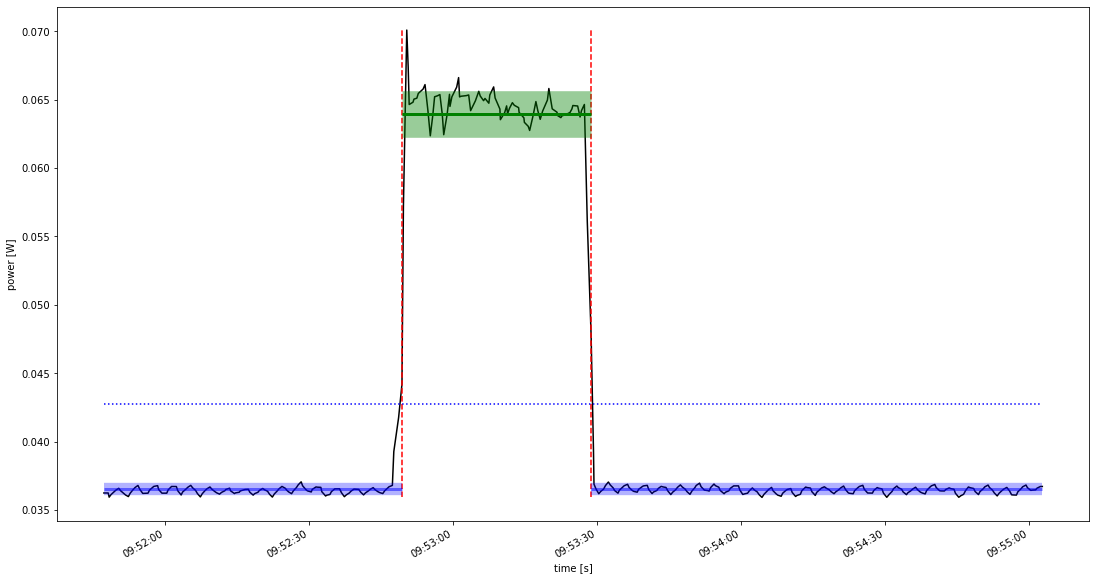

In [15]:

linewidth = 3

power_max = dataframe_power['power'].max()
power_min = dataframe_power['power'].min()

time_begin = dataframe_power.index[0]
time_end  = dataframe_power.index[-1]

power_threshold = power_min + (power_max - power_min) * threshold_percentage/100.0
experiment_begin = dataframe_power[dataframe_power['power'].gt(power_threshold)].index[0]
print("Experiment begin: {}".format(experiment_begin))
experiment_end = dataframe_power[dataframe_power['power'].gt(power_threshold)].index[-1]
print("Experiment end: {}".format(experiment_end))

ax = dataframe_power['power'].plot(color='k')
figure = ax.get_figure()
figure.set_size_inches(18.5, 10.5)

figure = ax.get_figure()
length = 72*figure.bbox_inches.height * ax.get_position().height
value_range = np.diff(ax.get_ylim())
ps= (length / value_range)

ax.vlines(x=[experiment_begin, experiment_end], ymin=power_min, ymax=power_max, colors=['r', 'r'], label='experiment begin / end', linestyles='dashed')
ax.hlines(y=[power_threshold], xmin=time_begin, xmax=time_end, colors=['b'], linestyles='dotted', label= 'detection threshold: {}%'.format(threshold_percentage))
# experiment mean
ax.hlines(y=[experiment_power.mean()], xmin=experiment_begin, xmax=experiment_end, colors=['g'], label='experiment mean power',linewidth=linewidth, alpha=1.0)
ax.hlines(y=[experiment_power.mean()], xmin=experiment_begin, xmax=experiment_end, colors=['g'], linewidth=experiment_power_std*ps, alpha=0.4)
# background mean left side 
ax.hlines(y=[background_power.mean()], xmin=time_begin, xmax=experiment_begin, colors=['b'], label='background mean power',linewidth=linewidth, alpha=0.5)
ax.hlines(y=[background_power.mean()], xmin=time_begin, xmax=experiment_begin, colors=['b'], linewidth=background_power_std*ps, alpha=0.3)

# backround mean right side
ax.hlines(y=[background_power.mean()], xmin=experiment_end, xmax=time_end, colors=['b'],linewidth=linewidth, alpha=0.5)
ax.hlines(y=[background_power.mean()], xmin=experiment_end, xmax=time_end, colors=['b'],linewidth=background_power_std*ps, alpha=0.3)
# ax.legend()

ax.set_ylabel("power [W]")
ax.set_xlabel("time [s]")
filename = measurements_directory + os.path.sep + "power_no_legend.png"
plt.savefig(filename)

filename = measurements_directory + os.path.sep + "power_no_legend.pdf"
fs = plt.rcParams.get('font.size')
plt.rcParams.update({'font.size': 20})
plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.rcParams.update({'font.size': fs})

In [18]:
figure_legend = plt.figure(figsize=(3,2), dpi=300)

legend = figure_legend.legend(ax.get_legend_handles_labels()[0], ax.get_legend_handles_labels()[1])


def export_legend(legend, filename="legend"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename+".png", dpi="figure", bbox_inches=bbox)
    fs = plt.rcParams.get('font.size')
    plt.rcParams.update({'font.size': 20})
    plt.savefig(filename+".pdf", format='pdf', bbox_inches='tight', pad_inches=0.1)
    plt.rcParams.update({'font.size': fs})

export_legend(legend)
plt.show()

<Figure size 900x600 with 0 Axes>